<a href="https://colab.research.google.com/github/basselkassem/covid19/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

In [1]:
!wget -O confirmed.csv https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv
!wget -O death.csv https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv
!wget -O recovered.csv https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv



--2020-04-29 22:35:44--  https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv
Resolving data.humdata.org (data.humdata.org)... 162.249.108.156
Connecting to data.humdata.org (data.humdata.org)|162.249.108.156|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘confirmed.csv’

confirmed.csv           [   <=>              ]  83.16K   113KB/s    in 0.7s    

2020-04-29 22:35:46 (113 KB/s) - ‘confirmed.csv’ saved [85152]

--2020-04-29 22:35:52--  https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv
Resolving data.humdata.org (data.humdata.org)... 162.249.108.156
Connecting to data.humdata.org 

In [80]:
from google.colab import drive
drive.mount("/content/drive", )
%cd /content/drive/'My Drive'/'Colab Notebooks'/timeseries

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/timeseries


# Import Data & libs

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from datetime import timedelta
from keras.models import  Sequential
from keras.layers import LSTM, Dense
print(tf.__version__)

2.2.0-rc3


In [243]:
!ls

confirmed.csv  death.csv  recovered.csv  sample_data


In [3]:
confirmed_df = pd.read_csv('confirmed.csv')
death_df =  pd.read_csv('death.csv')
recovered_df =  pd.read_csv('recovered.csv')
def prepare(df, name):
    cols_to_melt = df.columns.values[4:]
    res = pd.melt(df, id_vars='Country/Region', var_name='date', value_vars=cols_to_melt, value_name=name)
    res['date'] = pd.to_datetime(res['date'])
    res = res.sort_values(by = ['Country/Region', 'date'])
    res = res.set_index('date')
    res.columns = ['country', 'target']
    return res
confirmed_df = prepare(confirmed_df, 'target')
death_df = prepare(death_df, 'target')
recovered_df = prepare(recovered_df, 'target')
print('confirmed:',confirmed_df.shape)
print('deaths:', death_df.shape)
print('recovered:', recovered_df.shape)
confirmed_df.head()

confirmed: (25872, 2)
deaths: (25872, 2)
recovered: (24500, 2)


,country,target
date,,
2020-01-22,Afghanistan,0
2020-01-23,Afghanistan,0
2020-01-24,Afghanistan,0
2020-01-25,Afghanistan,0
2020-01-26,Afghanistan,0


In [245]:
print('confirmed dates:')
print(confirmed_df.index.min())
print(confirmed_df.index.max())
print(confirmed_df.index.max() - confirmed_df.index.min())
print('deaths dates:')
print(death_df.index.min())
print(death_df.index.max())
print(death_df.index.max() - death_df.index.min())

confirmed dates:
2020-01-22 00:00:00
2020-04-28 00:00:00
97 days 00:00:00
deaths dates:
2020-01-22 00:00:00
2020-04-28 00:00:00
97 days 00:00:00


# Visualize

In [0]:
def plot_series(df, color = 'red', title = 'Conr'):
    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    plt.plot(df, color = color, linewidth=2, markersize=12)
    x_ticks = np.linspace(df.index.min().value, df.index.max().value, 15)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 45)
    y_ticks = np.linspace(df.target.min(), df.target.max(), 10)
    plt.yticks(y_ticks)
    plt.legend(loc='best')
    plt.title(title)
    ax.grid(True)
    plt.show()
def plot2series(df, split, title = '', col = 'target'):
    df1 = df.iloc[0:split, :]
    df2 = df.iloc[split -1:,:]
    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    plt.plot(df1[col], color = 'red', linestyle='dashed', linewidth=2, markersize=12, label = 'Actual')
    plt.plot(df2[col], color = 'blue', linewidth=2, markersize=12, label = 'Predicted')
    x_ticks = np.linspace(df1.index.min().value, df2.index.max().value, 15)
    x_ticks = pd.to_datetime(x_ticks)
    plt.xticks(x_ticks, rotation = 45)
    y_ticks = np.linspace(df1[col].min(), df2[col].max(), 10)
    plt.yticks(y_ticks)
    plt.legend(loc='best')
    plt.title(title)
    ax.grid(True)
    plt.show()

# Modeling

In [0]:
def series_to_supervised(df, n_in=1, n_out=1, dropnan=True):
    cols, names = list(), list()
    #print('before lag:', df.shape)
    for i in range(n_in, 0, -1):
	    cols.append(df.shift(i))
	    names += ['target(t-%d)' % i]
    for i in range(0, n_out):
	    cols.append(df.shift(-i))
	    if i == 0:
		    names += ['target']
	    else:
		    names += ['target(t+%d)' % i]
	    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
	    agg.dropna(inplace=True)
    #print('after lag:', agg.shape)
    return agg

def normalize(df):
    ndf = df.copy()
    min_target = ndf['target'].min()
    max_target = ndf['target'].max()
    ndf['target']  = (ndf['target'] - min_target) / (max_target - min_target)
    return (ndf, min_target, max_target)

def denomalize(df, min_target, max_target):
    ddf = df.copy()
    ddf['target'] = ndf['target'] * (max_target - min_target) + min_target
    return ddf

def denomalize_value(value, min_target, max_target):
    return value * (max_target - min_target) + min_target
def do_forcast(df, days_num):
    forcast = df.copy()
    for itr in range(days_num):
        ndf, min_target, max_target = normalize(forcast)
        reframed = series_to_supervised(ndf, 20, 1,)
        train = reframed.values
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        tf.keras.backend.clear_session()
        input_shape=(train_X.shape[1], train_X.shape[2])
        model = Sequential()
        #model.add(LSTM(64, return_sequences = True, input_shape=input_shape))
        model.add(LSTM(64, input_shape=input_shape))
        #model.add(LSTM(64, ))
        model.add(Dense(64, activation="relu"))
        #model.add(Dense(64, activation="relu",))
        model.add(Dense(32, activation="relu",))
        model.add(Dense(1))
        model.compile(loss=tf.keras.losses.mse,
                    optimizer='adagrad',
                    metrics=["mse"])
        history = model.fit(train_X, train_y, epochs=20, batch_size=8, verbose=0)

        # plot history
        if itr == days_num -2:
            plt.plot(history.history['loss'], label='train')
            plt.show()
        yhat = model.predict(train_X)[-1, 0]
        yhat = denomalize_value(yhat, min_target, max_target)
        last_date = forcast.iloc[[-1]].index
        last_date = last_date + timedelta(days=1)
        print('In', last_date.values, 'Cases:', yhat )
        forcast = forcast.append(pd.DataFrame(yhat, index=last_date, columns = ['target']))
    return forcast

# forcasting New Cases

In [0]:
days_num = 90

In ['2020-04-29T00:00:00.000000000'] Cases: 46.735018491744995
In ['2020-04-30T00:00:00.000000000'] Cases: 45.57843290521291
In ['2020-05-01T00:00:00.000000000'] Cases: 46.72607942376494
In ['2020-05-02T00:00:00.000000000'] Cases: 42.247795788203035
In ['2020-05-03T00:00:00.000000000'] Cases: 47.512402630477624
In ['2020-05-04T00:00:00.000000000'] Cases: 46.516045513309294
In ['2020-05-05T00:00:00.000000000'] Cases: 46.3298611428787
In ['2020-05-06T00:00:00.000000000'] Cases: 46.6352625284288
In ['2020-05-07T00:00:00.000000000'] Cases: 46.66801697641493
In ['2020-05-08T00:00:00.000000000'] Cases: 46.59614466658957
In ['2020-05-09T00:00:00.000000000'] Cases: 47.21350342481479
In ['2020-05-10T00:00:00.000000000'] Cases: 47.993037197597666
In ['2020-05-11T00:00:00.000000000'] Cases: 46.116770174998095
In ['2020-05-12T00:00:00.000000000'] Cases: 47.77867754207425
In ['2020-05-13T00:00:00.000000000'] Cases: 46.383464652671385
In ['2020-05-14T00:00:00.000000000'] Cases: 47.853745615474466
In

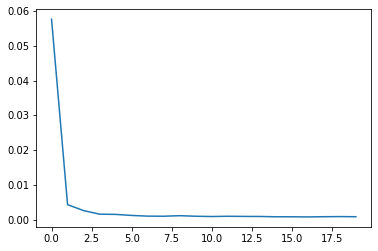

In ['2020-07-26T00:00:00.000000000'] Cases: 48.24547360979243
In ['2020-07-27T00:00:00.000000000'] Cases: 47.321122385173446


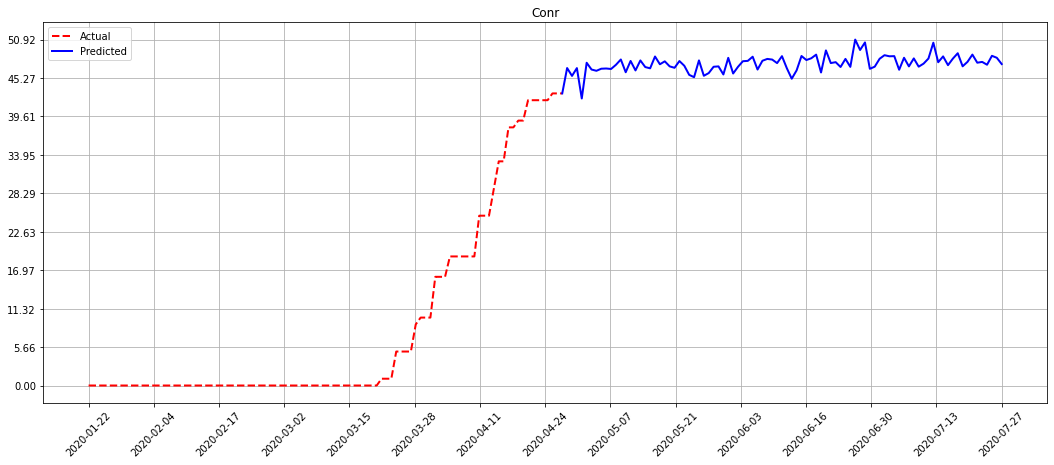

In [98]:
country =  'Syria'
title = 'New Covid19 Cases in ' + country
country_df = confirmed_df[confirmed_df['country'] == country]
country_df = country_df.drop(columns=['country'])
split = len(country_df)
forcast = country_df.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('syria.csv')

In ['2020-04-29T00:00:00.000000000'] Cases: 158913.05135679245
In ['2020-04-30T00:00:00.000000000'] Cases: 158595.02339601517
In ['2020-05-01T00:00:00.000000000'] Cases: 159239.7911067009
In ['2020-05-02T00:00:00.000000000'] Cases: 158032.24563074112
In ['2020-05-03T00:00:00.000000000'] Cases: 163451.1405057907
In ['2020-05-04T00:00:00.000000000'] Cases: 162514.92056028932
In ['2020-05-05T00:00:00.000000000'] Cases: 159869.51491097902
In ['2020-05-06T00:00:00.000000000'] Cases: 161711.47068479317
In ['2020-05-07T00:00:00.000000000'] Cases: 161702.03999593458
In ['2020-05-08T00:00:00.000000000'] Cases: 164152.38236804758
In ['2020-05-09T00:00:00.000000000'] Cases: 163099.46068687263
In ['2020-05-10T00:00:00.000000000'] Cases: 153976.67030791834
In ['2020-05-11T00:00:00.000000000'] Cases: 158001.88890207902
In ['2020-05-12T00:00:00.000000000'] Cases: 162028.7903862834
In ['2020-05-13T00:00:00.000000000'] Cases: 160229.24279613027
In ['2020-05-14T00:00:00.000000000'] Cases: 164098.7157872

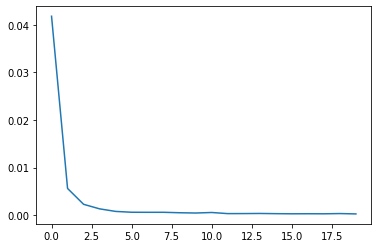

In ['2020-07-26T00:00:00.000000000'] Cases: 159401.76751402617
In ['2020-07-27T00:00:00.000000000'] Cases: 157663.4277875487


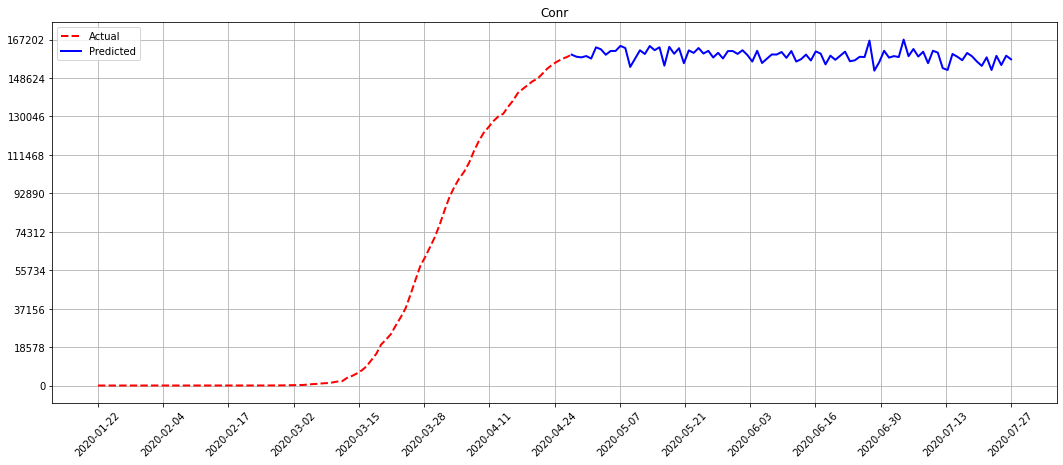

In [99]:
country =  'Germany'
title = 'New Covid19 Cases in ' + country
country_df = confirmed_df[confirmed_df['country'] == country]
country_df = country_df.drop(columns=['country'])
split = len(country_df)
forcast = country_df.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('germany.csv')

In ['2020-04-29T00:00:00.000000000'] Cases: 3061349.4870676994
In ['2020-04-30T00:00:00.000000000'] Cases: 3083581.13158834
In ['2020-05-01T00:00:00.000000000'] Cases: 3232435.424688697
In ['2020-05-02T00:00:00.000000000'] Cases: 3252735.6951814024
In ['2020-05-03T00:00:00.000000000'] Cases: 3231083.58798493
In ['2020-05-04T00:00:00.000000000'] Cases: 3348695.985769532
In ['2020-05-05T00:00:00.000000000'] Cases: 3428348.26607934
In ['2020-05-06T00:00:00.000000000'] Cases: 3452434.6549139414
In ['2020-05-07T00:00:00.000000000'] Cases: 3466925.079328593
In ['2020-05-08T00:00:00.000000000'] Cases: 3485615.5921118953
In ['2020-05-09T00:00:00.000000000'] Cases: 3481565.1467647296
In ['2020-05-10T00:00:00.000000000'] Cases: 3504253.581666697
In ['2020-05-11T00:00:00.000000000'] Cases: 3493897.5780862295
In ['2020-05-12T00:00:00.000000000'] Cases: 3527347.5803345945
In ['2020-05-13T00:00:00.000000000'] Cases: 3617856.9838845553
In ['2020-05-14T00:00:00.000000000'] Cases: 3647527.231952311
In 

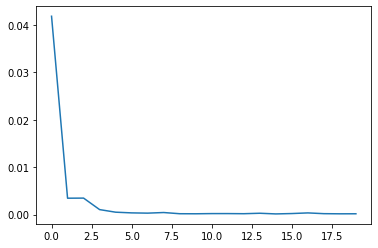

In ['2020-07-26T00:00:00.000000000'] Cases: 3672166.059429128
In ['2020-07-27T00:00:00.000000000'] Cases: 3659898.971837157


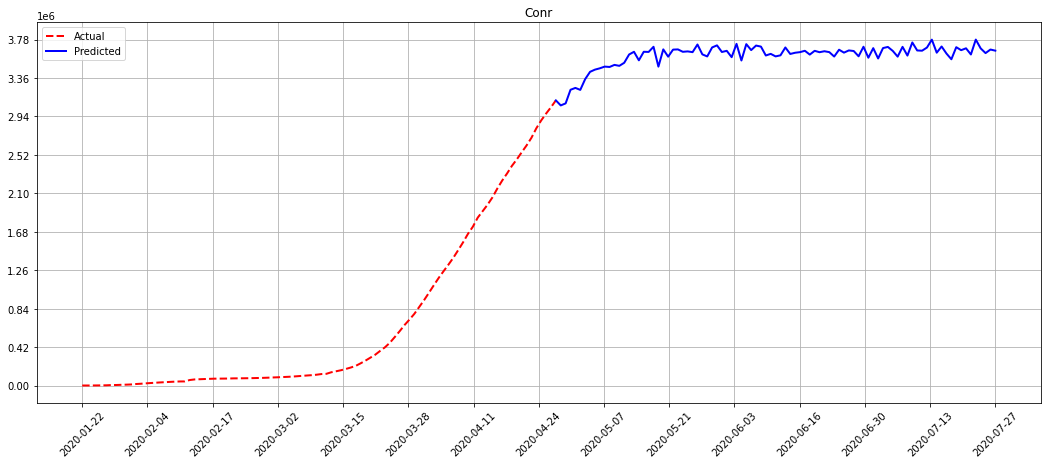

In [100]:
gb = confirmed_df.groupby(by = ['date']).sum()
title = 'New Covid19 Cases in the World'
split = len(gb)
forcast = gb.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('global.csv')

# forcasting Deaths

In [0]:
days_num = 90

In ['2020-04-29T00:00:00.000000000'] Cases: 3.0135565996170044
In ['2020-04-30T00:00:00.000000000'] Cases: 2.986684613944739
In ['2020-05-01T00:00:00.000000000'] Cases: 3.0774923215751215
In ['2020-05-02T00:00:00.000000000'] Cases: 2.9789879711425202
In ['2020-05-03T00:00:00.000000000'] Cases: 2.9885339993933986
In ['2020-05-04T00:00:00.000000000'] Cases: 3.045515942628721
In ['2020-05-05T00:00:00.000000000'] Cases: 3.0350529336275467
In ['2020-05-06T00:00:00.000000000'] Cases: 2.834877448270824
In ['2020-05-07T00:00:00.000000000'] Cases: 2.9704605454334283
In ['2020-05-08T00:00:00.000000000'] Cases: 2.747313399080299
In ['2020-05-09T00:00:00.000000000'] Cases: 3.086644519525763
In ['2020-05-10T00:00:00.000000000'] Cases: 3.4065850781494067
In ['2020-05-11T00:00:00.000000000'] Cases: 3.329950185127507
In ['2020-05-12T00:00:00.000000000'] Cases: 4.009690490148856
In ['2020-05-13T00:00:00.000000000'] Cases: 3.520464598176899
In ['2020-05-14T00:00:00.000000000'] Cases: 3.6839516062490225


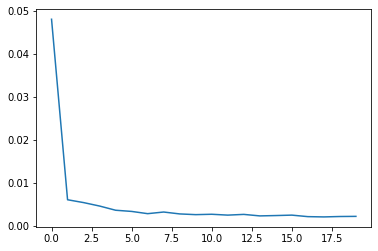

In ['2020-07-26T00:00:00.000000000'] Cases: 4.064950518360071
In ['2020-07-27T00:00:00.000000000'] Cases: 4.062257085765007


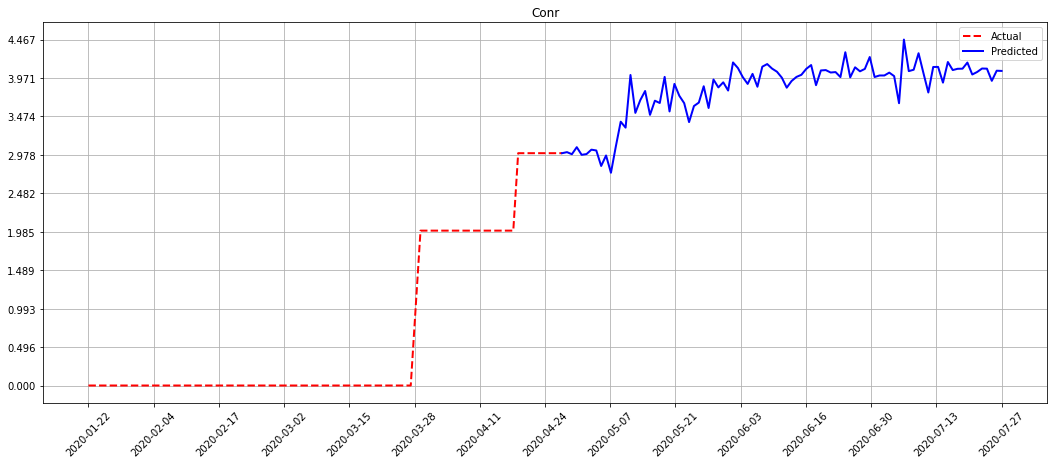

In [102]:
country =  'Syria'
title = 'Covid19 Fatalities in ' + country
country_df = death_df[death_df['country'] == country]
country_df = country_df.drop(columns=['country'])
split = len(country_df)
forcast = country_df.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('dsyria.csv')

In ['2020-04-29T00:00:00.000000000'] Cases: 6259.098977088928
In ['2020-04-30T00:00:00.000000000'] Cases: 6448.241807460785
In ['2020-05-01T00:00:00.000000000'] Cases: 6521.031400379406
In ['2020-05-02T00:00:00.000000000'] Cases: 6653.400764381777
In ['2020-05-03T00:00:00.000000000'] Cases: 6739.524650728641
In ['2020-05-04T00:00:00.000000000'] Cases: 6764.460209355849
In ['2020-05-05T00:00:00.000000000'] Cases: 6781.223371829538
In ['2020-05-06T00:00:00.000000000'] Cases: 6635.461888086189
In ['2020-05-07T00:00:00.000000000'] Cases: 7014.0891283602205
In ['2020-05-08T00:00:00.000000000'] Cases: 6611.790704977748
In ['2020-05-09T00:00:00.000000000'] Cases: 6820.893323931425
In ['2020-05-10T00:00:00.000000000'] Cases: 6906.864455619102
In ['2020-05-11T00:00:00.000000000'] Cases: 6930.148991861826
In ['2020-05-12T00:00:00.000000000'] Cases: 6984.906428237213
In ['2020-05-13T00:00:00.000000000'] Cases: 7025.197309129934
In ['2020-05-14T00:00:00.000000000'] Cases: 6972.394902539872
In ['20

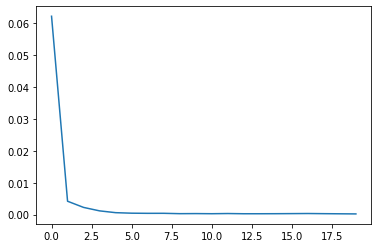

In ['2020-07-26T00:00:00.000000000'] Cases: 6783.535880719693
In ['2020-07-27T00:00:00.000000000'] Cases: 6717.326436544009


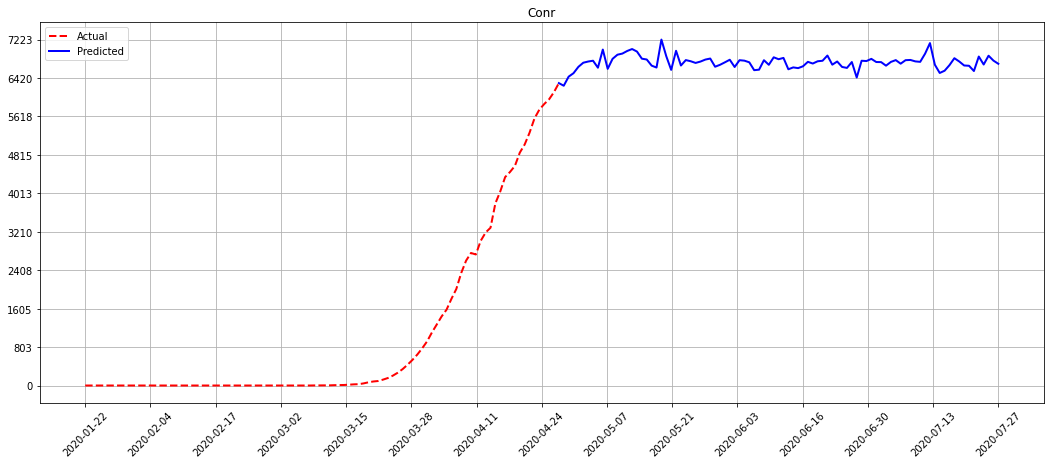

In [103]:
country =  'Germany'
title = 'Covid19 Fatalities in ' + country
country_df = death_df[death_df['country'] == country]
country_df = country_df.drop(columns=['country'])
split = len(country_df)
forcast = country_df.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('dgermany.csv')

In ['2020-04-29T00:00:00.000000000'] Cases: 215992.91567134857
In ['2020-04-30T00:00:00.000000000'] Cases: 219450.62314605713
In ['2020-05-01T00:00:00.000000000'] Cases: 223859.72123266905
In ['2020-05-02T00:00:00.000000000'] Cases: 236715.70897299022
In ['2020-05-03T00:00:00.000000000'] Cases: 232621.0729554404
In ['2020-05-04T00:00:00.000000000'] Cases: 231246.37017378586
In ['2020-05-05T00:00:00.000000000'] Cases: 230432.4598968572
In ['2020-05-06T00:00:00.000000000'] Cases: 240020.78571270965
In ['2020-05-07T00:00:00.000000000'] Cases: 236595.0858490003
In ['2020-05-08T00:00:00.000000000'] Cases: 234410.8320352029
In ['2020-05-09T00:00:00.000000000'] Cases: 238345.6017421075
In ['2020-05-10T00:00:00.000000000'] Cases: 239886.6588411928
In ['2020-05-11T00:00:00.000000000'] Cases: 240655.97143680212
In ['2020-05-12T00:00:00.000000000'] Cases: 238974.4463365475
In ['2020-05-13T00:00:00.000000000'] Cases: 244669.83001278757
In ['2020-05-14T00:00:00.000000000'] Cases: 242449.71108732777

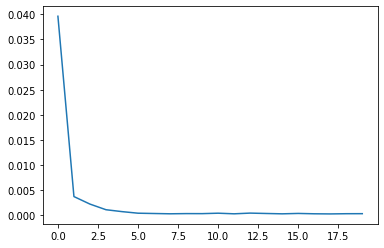

In ['2020-07-26T00:00:00.000000000'] Cases: 237495.43719249876
In ['2020-07-27T00:00:00.000000000'] Cases: 238818.73195662905


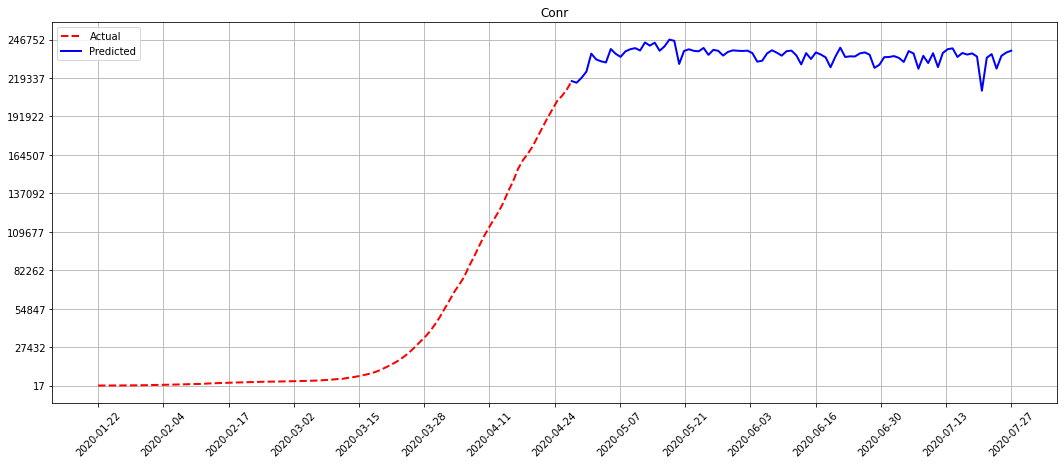

In [104]:
gb = death_df.groupby(by = ['date']).sum()
title = 'Covid19 Fatalities in the World'
split = len(gb)
forcast = gb.copy()
res = do_forcast(forcast, days_num)
plot2series(res, split, title)
to_save = res.reset_index(drop = False)
to_save.to_csv('dglobal.csv')

# Visualize Results

In [0]:
import seaborn as sns
def read_file(name):
    df = pd.read_csv(name + '.csv')
    df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    df = df[['target']]
    df.columns = ['new_cases']
    #world['region'] = 'World'

    ddf = pd.read_csv('d' + name + '.csv')
    ddf.date = pd.to_datetime(ddf.date)
    ddf = ddf.set_index('date')
    ddf = ddf[['target']]
    ddf.columns = ['deaths']
    return pd.concat([df, ddf], axis = 1)

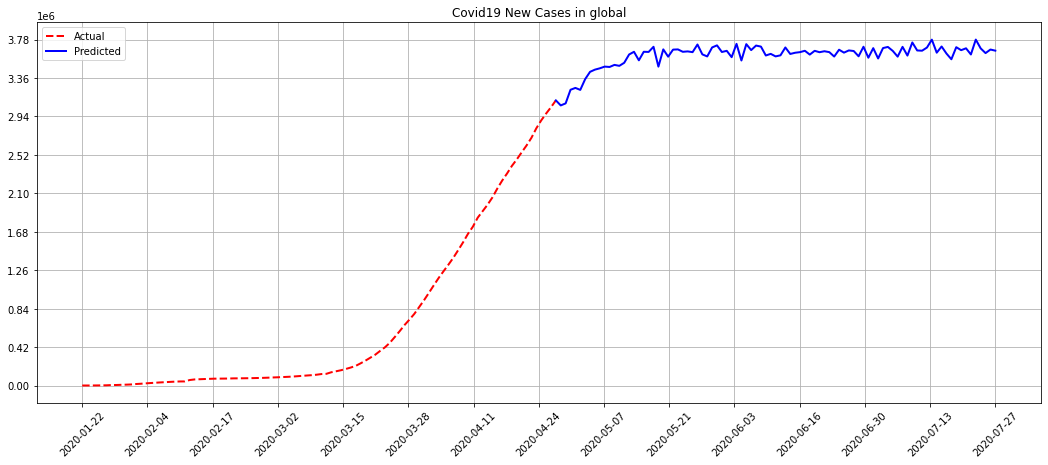

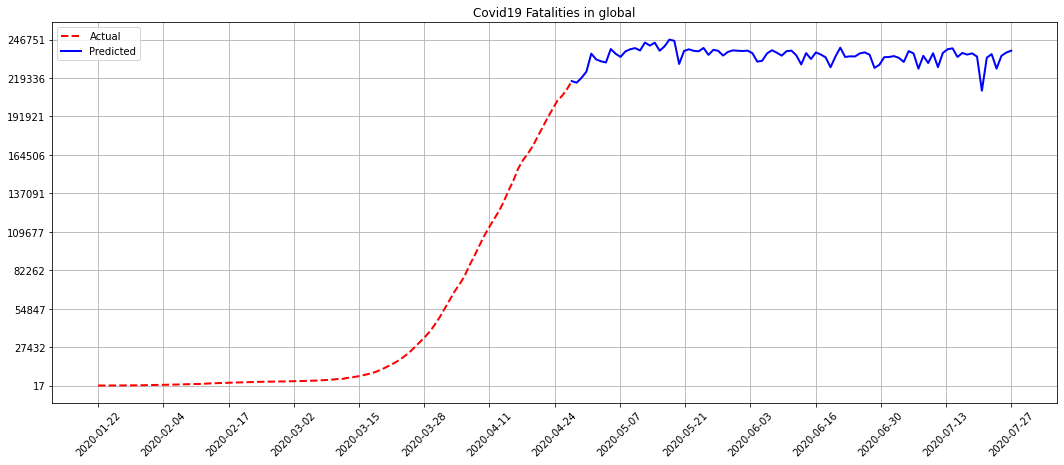

In [150]:
name = 'global'
country = read_file(name)
title = 'Covid19 New Cases in ' + name
plot2series(country, split, title, col = 'new_cases')

title = 'Covid19 Fatalities in ' + name
plot2series(country, split, title, col = 'deaths')